In [1]:
import psfr
from psfr.psfr import shift_psf, one_step_psf_estimate

import astropy.io.fits as pyfits
from astropy.io import fits
import os
import matplotlib.pyplot as plt
import numpy as np
import copy
import scipy
from scipy.ndimage import interpolation
from lenstronomy.Util import util, kernel_util, image_util
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

%load_ext autoreload
%autoreload 2

vmin, vmax = -5, -1  # log10 minimum and maximum scale being plotted in PSF

In [2]:
def max2d(array):
    shp = np.shape(array)
    imax = np.argmax(array)
    i1,i2 = int(imax/shp[1]),imax%shp[1]
    return i1,i2

In [3]:
filter0 = 'f115w'

filename200 = f'/n/holyscratch01/dvorkin_lab/nephremidze/JWST-CAB-systems/Abell-S1063/jw01840-o010_t003_nircam_clear-{filter0}_i2d.fits'
data200 = fits.open(filename200)

# filename150 = '../smacs_0723/JWST/jw02736-o001_t001_nircam_clear-f150w/jw02736-o001_t001_nircam_clear-f150w_i2d.fits'#'smacs_0723/JWST/jw02736-o001_t001_nircam_clear-f090w/jw02736-o001_t001_nircam_clear-f090w_i2d.fits'
# data150 = fits.open(filename150)

# filename090 = '../smacs_0723/JWST/jw02736-o001_t001_nircam_clear-f090w/jw02736-o001_t001_nircam_clear-f090w_i2d.fits'#'smacs_0723/JWST/jw02736-o001_t001_nircam_clear-f090w/jw02736-o001_t001_nircam_clear-f090w_i2d.fits'
# data090 = fits.open(filename090)

print(np.shape(data200[1].data))
# print(np.shape(data150[1].data))
# print(np.shape(data090[1].data))

dataarr = data200[1].data #np.flip(data200[1].data,axis=1)
dataarr_err = data200[2].data #np.flip(data200[2].data,axis=1)

# dataarr = dataarr[:4750,:4750]
# dataarr_err = dataarr_err[:4750,:4750] 

coverage_mask = (dataarr == 0)

# dataarr2 = np.flip(data150[1].data,axis=1)
# dataarr_err2 = np.flip(data150[2].data,axis=1)

# dataarr2 = dataarr2[:4750,:4750]
# dataarr_err2 = dataarr_err2[:4750,:4750] 

# coverage_mask2 = (dataarr2 == 0)

# dataarr3 = np.flip(data090[1].data,axis=1)
# dataarr_err3 = np.flip(data090[2].data,axis=1)

# dataarr3 = dataarr3[:4750,:4750]
# dataarr_err3 = dataarr_err3[:4750,:4750] 

# coverage_mask3 = (dataarr3 == 0)

(4519, 4540)


0.0
1.4805303955078124


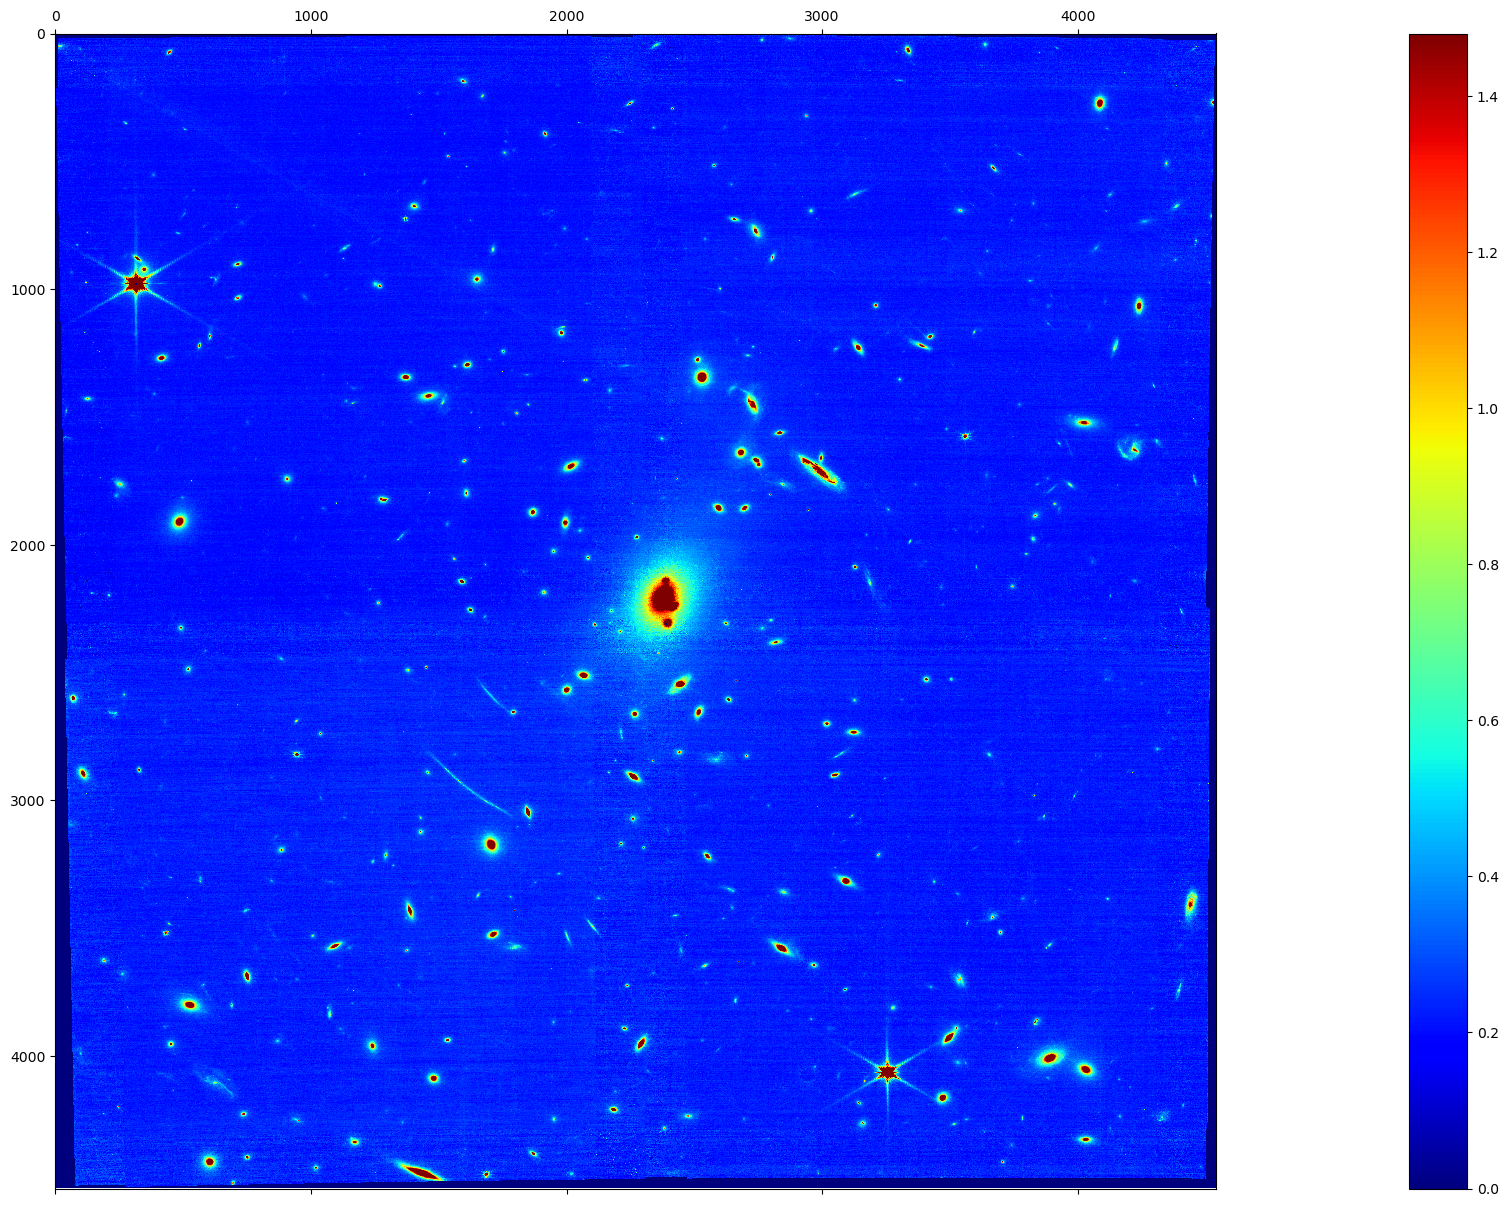

In [4]:
cmap_string = 'jet'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

# here we plot full image of the signal and the noise

f, axes = plt.subplots(1, 1, figsize=(50,15), sharex=False, sharey=False)
ax = axes

vmin = 0.
vmax = np.max(dataarr)/500.
print(vmin)
print(vmax)

#ext = 1.

#extent = [-ext,ext,-ext,ext]

im0 = ax.matshow(dataarr, origin='upper', vmin=vmin, vmax=vmax, cmap='jet')
#ax[0,0].get_xaxis().set_visible(False)
#ax[0,0].get_yaxis().set_visible(False)
ax.autoscale(False)
f.colorbar(im0, ax=axes)

In [5]:
from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground

sigma_clip = SigmaClip(sigma=3.)
bkg_estimator = MedianBackground()
bkg = Background2D(dataarr, (30, 30), filter_size=(19, 19),mask=coverage_mask, exclude_percentile = 50.,
                   sigma_clip=sigma_clip, bkg_estimator=bkg_estimator,edge_method='crop')

# bkg2 = Background2D(dataarr2, (30, 30), filter_size=(19, 19),mask=coverage_mask2, exclude_percentile = 50.,
#                    sigma_clip=sigma_clip, bkg_estimator=bkg_estimator,edge_method='crop')

# bkg3 = Background2D(dataarr3, (30, 30), filter_size=(19, 19),mask=coverage_mask3, exclude_percentile = 50.,
#                    sigma_clip=sigma_clip, bkg_estimator=bkg_estimator,edge_method='crop')

0.0
0.3516947478055954


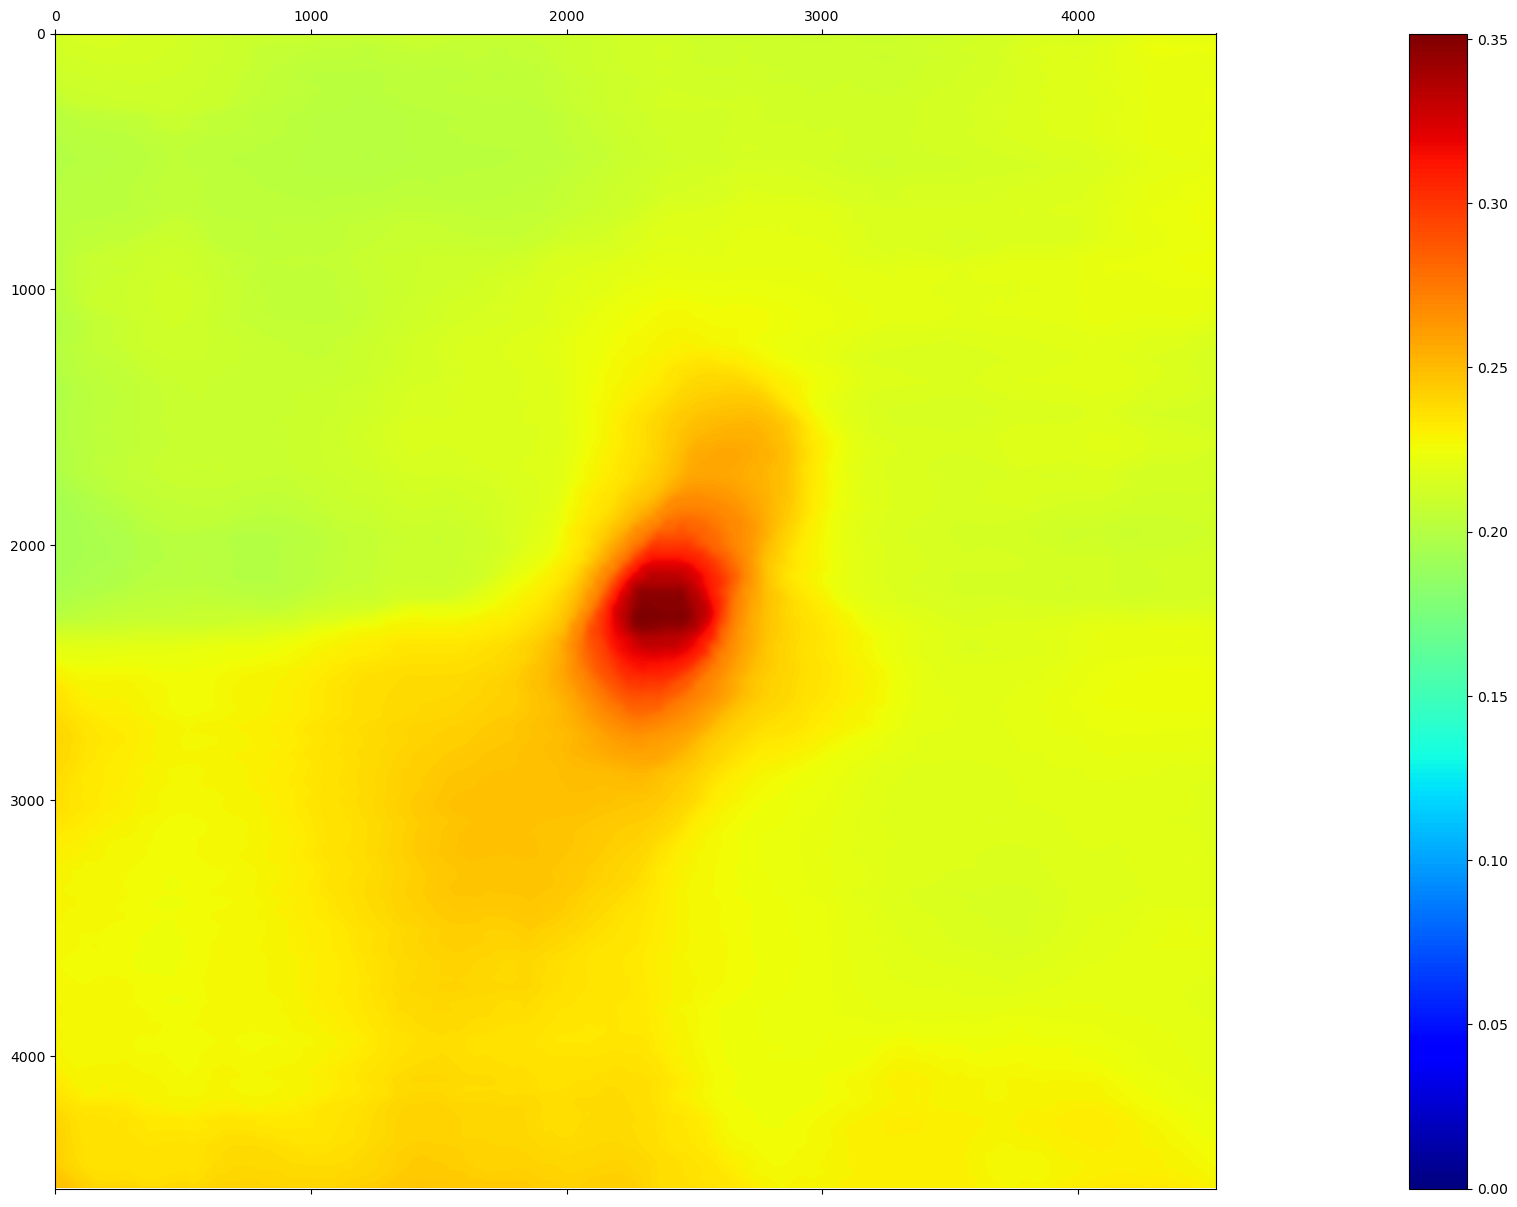

In [6]:
cmap_string = 'jet'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

# here we plot full image of the signal and the noise

f, axes = plt.subplots(1, 1, figsize=(50,15), sharex=False, sharey=False)
ax = axes

vmin = 0.
vmax = np.max(bkg.background)
print(vmin)
print(vmax)

#ext = 1.

#extent = [-ext,ext,-ext,ext]

im0 = ax.matshow(bkg.background, origin='upper', vmin=vmin, vmax=vmax, cmap='jet')
#ax[0,0].get_xaxis().set_visible(False)
#ax[0,0].get_yaxis().set_visible(False)
ax.autoscale(False)
f.colorbar(im0, ax=axes)

In [7]:
dataarr = dataarr-bkg.background

# dataarr2 = dataarr2-bkg2.background

# dataarr3 = dataarr3-bkg3.background

In [10]:
filter = "f115w"

dataarrX = dataarr
dataarr_errX = dataarr_err

In [11]:
# Centering on max pixel

def recenter_tomax(xc3, yc3, size, array):

    y_max, x_max = np.unravel_index(np.argmax(array, axis=None), array.shape)

    yc3 = yc3 - size + y_max # These are the corrected brightest pixel values
    xc3 = xc3 - size + x_max

    ymin3 = yc3-size
    ymax3 = yc3+size

    xmin3 = xc3-size
    xmax3 = xc3+size
    
    array_sci = dataarrX[ymin3:ymax3,xmin3:xmax3]
    array_err = dataarr_errX[ymin3:ymax3,xmin3:xmax3]
    
    return xc3, yc3, array_sci, array_err

In [25]:
size = 60

xshift = 1
yshift = 2

yc3 = 1964 + yshift
xc3 = 1354 + xshift

ymin3 = yc3-size
ymax3 = yc3+size

xmin3 = xc3-size
xmax3 = xc3+size

array200sci = dataarr[ymin3:ymax3,xmin3:xmax3]
array200err = dataarr_err[ymin3:ymax3,xmin3:xmax3]

#im1ctr_x, im1ctr_y, array200sci, array200err = recenter_tomax(xc3, yc3, size, array200sci)

np.save(filter+"_image1_.npy", array200sci)
np.save(filter+"_error1_.npy", array200err)

yc3 = 2729 + yshift
xc3 = 2212 + xshift

ymin3 = yc3-size
ymax3 = yc3+size

xmin3 = xc3-size
xmax3 = xc3+size

array200sci2 = dataarr[ymin3:ymax3,xmin3:xmax3]
array200err2 = dataarr_err[ymin3:ymax3,xmin3:xmax3]

#im2ctr_x, im2ctr_y, array200sci2, array200err2 = recenter_tomax(xc3, yc3, size, array200sci2)

np.save(filter+"_image2_.npy", array200sci2)
np.save(filter+"_error2_.npy", array200err2)

yc3 = 2814 + yshift
xc3 = 3075 + xshift

ymin3 = yc3-size
ymax3 = yc3+size

xmin3 = xc3-size
xmax3 = xc3+size

array200sci3 = dataarr[ymin3:ymax3,xmin3:xmax3]
array200err3 = dataarr_err[ymin3:ymax3,xmin3:xmax3]

#im3ctr_x, im3ctr_y, array200sci3, array200err3 = recenter_tomax(xc3, yc3, size, array200sci3)

np.save(filter+"_image3_.npy", array200sci3)
np.save(filter+"_error3_.npy", array200err3)

/tmp/ipykernel_1846773/301278737.py:4: RuntimeWarning: invalid value encountered in log10
  vmin = np.min(np.log10(array200sci))
/tmp/ipykernel_1846773/301278737.py:5: RuntimeWarning: invalid value encountered in log10
  vmax = np.max(np.log10(array200sci))
/tmp/ipykernel_1846773/301278737.py:18: RuntimeWarning: invalid value encountered in log10
  axs[0, 0].imshow(np.log10(array200sci), cmap=cmap, vmin=vmin, vmax=vmax)
/tmp/ipykernel_1846773/301278737.py:22: RuntimeWarning: invalid value encountered in log10
  axs[0, 1].imshow(np.log10(array200sci2), cmap=cmap, vmin=vmin, vmax=vmax)
/tmp/ipykernel_1846773/301278737.py:26: RuntimeWarning: invalid value encountered in log10
  axs[0, 2].imshow(np.log10(array200sci3), cmap=cmap, vmin=vmin, vmax=vmax)


nan
nan
-1.7586932
-1.4231749


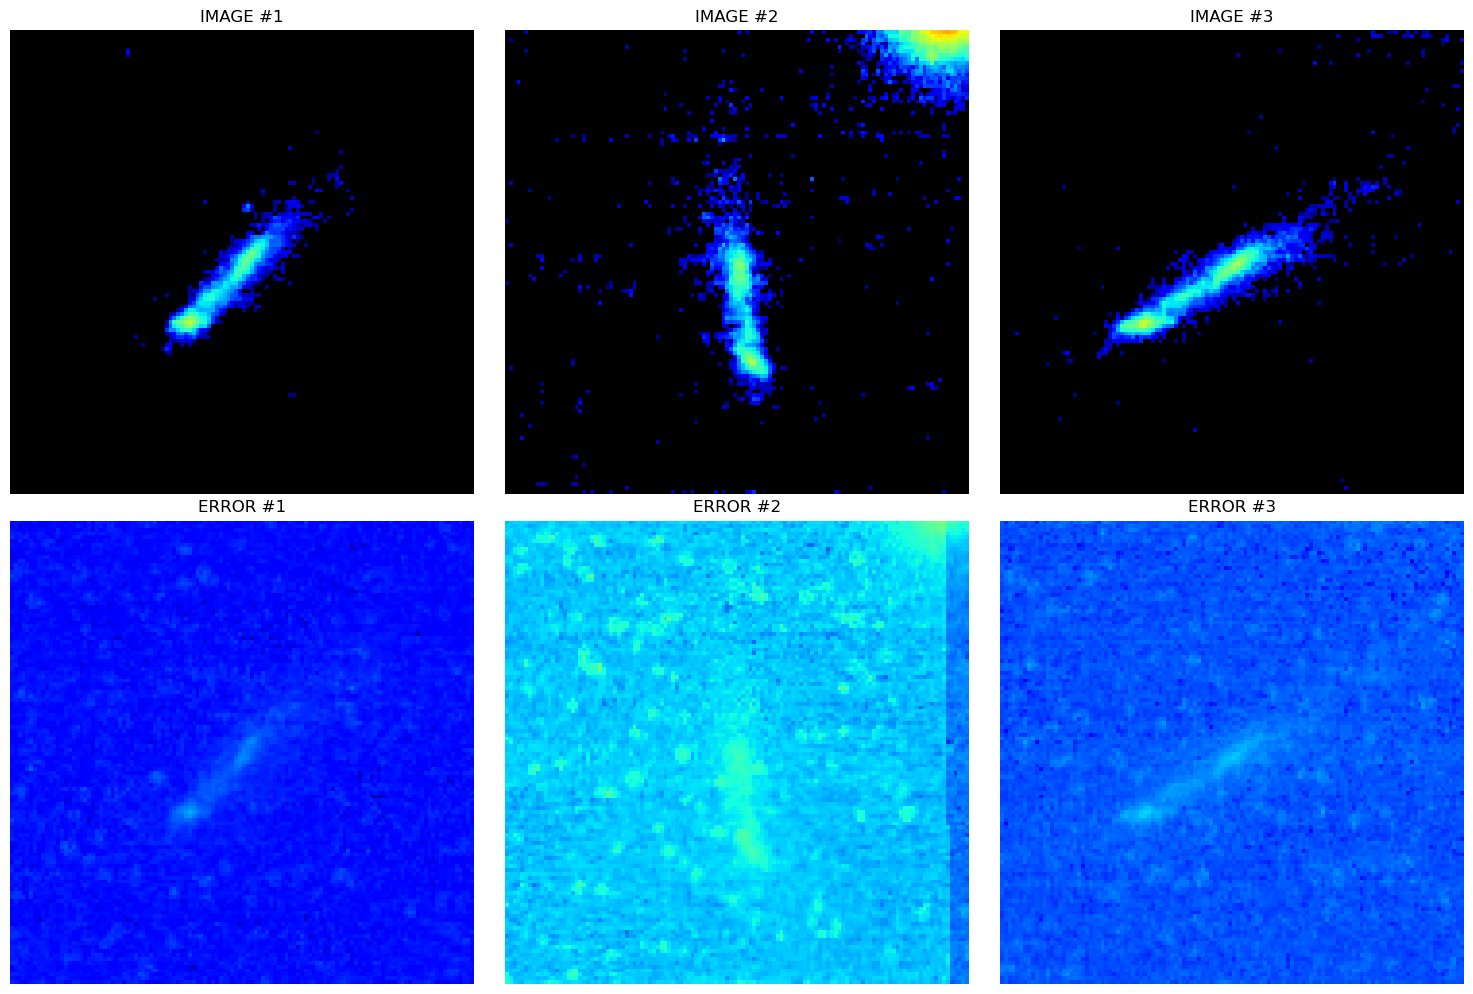

In [26]:
# Plotting
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

vmin = np.min(np.log10(array200sci))
vmax = np.max(np.log10(array200sci))
print(vmin)
print(vmax)

cmap_string = 'jet'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

vmin = -1.2
vmax = 0.5

# Plot sci files in the first row
axs[0, 0].imshow(np.log10(array200sci), cmap=cmap, vmin=vmin, vmax=vmax)
axs[0, 0].set_title('IMAGE #1')
axs[0, 0].axis('off')

axs[0, 1].imshow(np.log10(array200sci2), cmap=cmap, vmin=vmin, vmax=vmax)
axs[0, 1].set_title('IMAGE #2')
axs[0, 1].axis('off')

axs[0, 2].imshow(np.log10(array200sci3), cmap=cmap, vmin=vmin, vmax=vmax)
axs[0, 2].set_title('IMAGE #3')
axs[0, 2].axis('off')

vmin = np.min(np.log10(array200err))
vmax = np.max(np.log10(array200err))
print(vmin)
print(vmax)

vmin = -1.8
vmax = -0.5

# Plot err files in the second row
axs[1, 0].imshow(np.log10(array200err), cmap=cmap, vmin=vmin, vmax=vmax)
axs[1, 0].set_title('ERROR #1')
axs[1, 0].axis('off')

axs[1, 1].imshow(np.log10(array200err2), cmap=cmap, vmin=vmin, vmax=vmax)
axs[1, 1].set_title('ERROR #2')
axs[1, 1].axis('off')

axs[1, 2].imshow(np.log10(array200err3), cmap=cmap, vmin=vmin, vmax=vmax)
axs[1, 2].set_title('ERROR #3')
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()


In [24]:
max2d(array200sci)

(76, 45)

-1.2
0.5


/tmp/ipykernel_1845978/378550630.py:38: RuntimeWarning: invalid value encountered in log10
  im0 = axbig.imshow(np.log10(dataarrX), origin='upper', vmin=vmin, vmax=vmax, cmap=cmap)
/tmp/ipykernel_1845978/378550630.py:87: RuntimeWarning: invalid value encountered in log10
  im0 = ax[3,0].imshow(np.log10(array200sci), origin='upper', vmin=vmin, vmax=vmax, cmap=cmap)
/tmp/ipykernel_1845978/378550630.py:88: RuntimeWarning: invalid value encountered in log10
  im0 = ax[3,1].imshow(np.log10(array200sci2), origin='upper', vmin=vmin, vmax=vmax, cmap=cmap)
/tmp/ipykernel_1845978/378550630.py:89: RuntimeWarning: invalid value encountered in log10
  im0 = ax[3,2].imshow(np.log10(array200sci3), origin='upper', vmin=vmin, vmax=vmax, cmap=cmap)


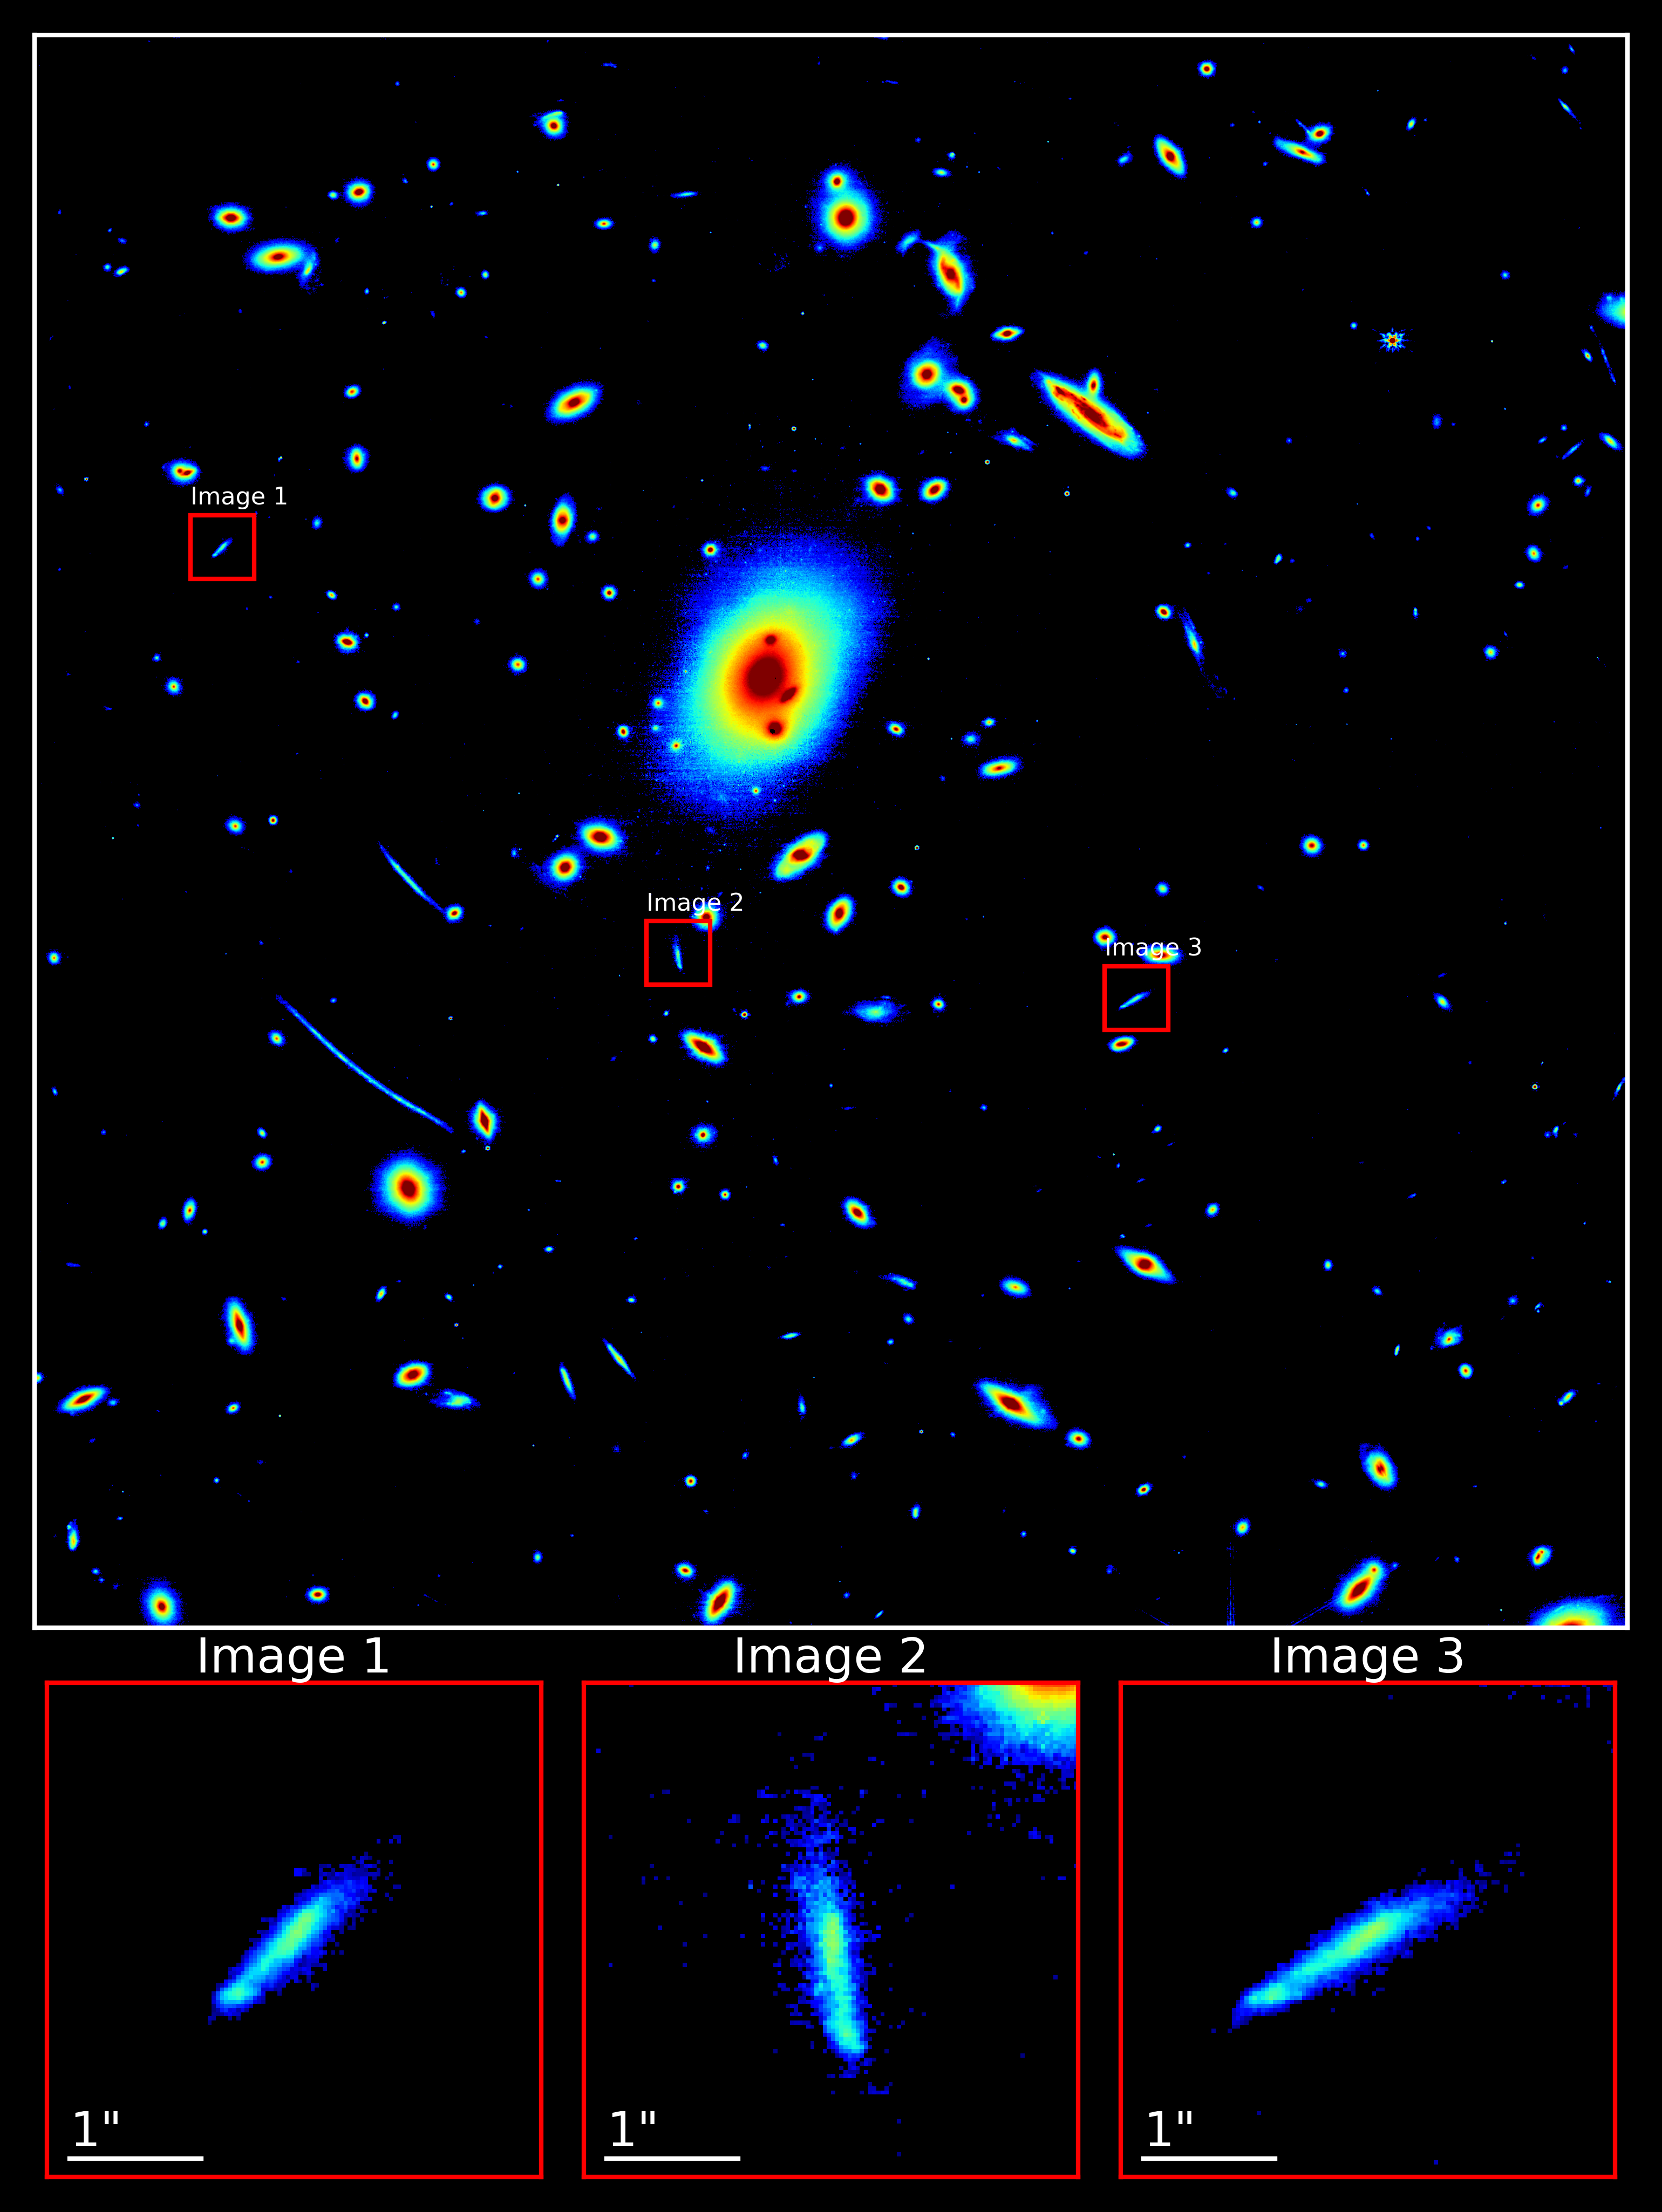

In [12]:
import matplotlib as mpl
import matplotlib.lines as lines

cmap_string = 'jet'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

# here we plot full image of the signal and the noise

scal = 2.

f, axes = plt.subplots(4, 3, figsize=(15*scal,20*scal))


f.patch.set_facecolor('black')

ax = axes
gs = axes[1, 0].get_gridspec()

fontsss = 32

for axi in axes[:3, :]:
    for axij in axi:
        axij.remove()

vmin = -1.2
vmax = 0.5
print(vmin)
print(vmax)

#ext = 1.

#extent = [-ext,ext,-ext,ext]

axbig = f.add_subplot(gs[:3, :])

im0 = axbig.imshow(np.log10(dataarrX), origin='upper', vmin=vmin, vmax=vmax, cmap=cmap)
deltaPix = 0.031230659851709842

txtclr = 'white'

x1 = [1350,1350+10/deltaPix]
y1 = [3450,3450]
#axbig.add_artist(lines.Line2D(x1, y1,color="white", linewidth=3*scal))
#axbig.text(1350,3435, '10"', fontsize = fontsss*scal,color=txtclr)

#ax[0,0].get_xaxis().set_visible(False)
#ax[0,0].get_yaxis().set_visible(False)
#rectangle = plt.Rectangle((1733,2370), 120, 120, fill=None,ec="red",linewidth=10)
rectangle1 = mpl.patches.Rectangle((im1ctr_x-size,im1ctr_y-size), 120, 120, fill=None,ec="red",linewidth=3*scal)
rectangle2 = mpl.patches.Rectangle((im2ctr_x-size,im2ctr_y-size), 120, 120, fill=None,ec="red",linewidth=3*scal)
rectangle3 = mpl.patches.Rectangle((im3ctr_x-size,im3ctr_y-size), 120, 120, fill=None,ec="red",linewidth=3*scal)


axbig.text(im1ctr_x-size,im1ctr_y-size-20, 'Image 1', fontsize = 0.5*fontsss*scal,color=txtclr)
axbig.text(im2ctr_x-size,im2ctr_y-size-20, 'Image 2', fontsize = 0.5*fontsss*scal,color=txtclr)
axbig.text(im3ctr_x-size,im3ctr_y-size-20, 'Image 3', fontsize = 0.5*fontsss*scal,color=txtclr)


axbig.add_patch(rectangle1)
axbig.add_patch(rectangle2)
axbig.add_patch(rectangle3)


axbig.set_xticks([])
axbig.set_yticks([])

axbig.set_xticklabels([])
axbig.set_yticklabels([])



axbig.autoscale(False)
axbig.set_xlim(1000,4000)
axbig.set_ylim(4000,1000)

for direc in ['left', 'right', 'top', 'bottom']:

    axbig.spines[direc].set_color('white') 
    axbig.spines[direc].set_linewidth(3*scal)

ax[3,0].set_title('Image 1',fontsize = fontsss*scal, color=txtclr)
ax[3,1].set_title('Image 2',fontsize = fontsss*scal, color=txtclr)
ax[3,2].set_title('Image 3',fontsize = fontsss*scal, color=txtclr)

im0 = ax[3,0].imshow(np.log10(array200sci), origin='upper', vmin=vmin, vmax=vmax, cmap=cmap)
im0 = ax[3,1].imshow(np.log10(array200sci2), origin='upper', vmin=vmin, vmax=vmax, cmap=cmap)
im0 = ax[3,2].imshow(np.log10(array200sci3), origin='upper', vmin=vmin, vmax=vmax, cmap=cmap)


x1 = [5,5+1/deltaPix]
y1 = [115,115]
ax[3,0].add_artist(lines.Line2D(x1, y1,color="white", linewidth=3*scal))
ax[3,0].text(5,112, '1"', fontsize = fontsss*scal,color=txtclr)

ax[3,1].add_artist(lines.Line2D(x1, y1,color="white", linewidth=3*scal))
ax[3,1].text(5,112, '1"', fontsize = fontsss*scal,color=txtclr)


ax[3,2].add_artist(lines.Line2D(x1, y1,color="white", linewidth=3*scal))
ax[3,2].text(5,112, '1"', fontsize = fontsss*scal,color=txtclr)


for axk in ax[3,:]:
    axk.set_xticklabels([])
    axk.set_yticklabels([])
    
    axk.set_xticks([])
    axk.set_yticks([])
    
    for direc in ['left', 'right', 'top', 'bottom']:
        
        axk.spines[direc].set_color('red') 
        axk.spines[direc].set_linewidth(3*scal)

#f.colorbar(im0, ax=axes)
#plt.plot(x1,y1,color="white", linewidth=3*scal,linestyle='dashed')
f.add_artist(lines.Line2D([-0.01, 1.01], [1.01, -0.01],alpha=0.))
plt.tight_layout()
plt.savefig("lensed_images.png")

In [13]:
# Masking Lensed Images

In [14]:
array200sci = np.load(filter+'_image1_.npy')
array200err = np.load(filter+'_error1_.npy')

array200sci2 = np.load(filter+'_image2_.npy')
array200err2 = np.load(filter+'_error2_.npy')

array200sci3 = np.load(filter+'_image3_.npy')
array200err3 = np.load(filter+'_error3_.npy')

In [27]:
print(max2d(array200sci*likemask))
print(max2d(array200sci2*likemask2))
print(max2d(array200sci3*likemask3))

(60, 60)
(60, 60)
(60, 60)


In [15]:
cnk=1

In [16]:
def makemask(array,a,b,angle):
    #makes an elliptical mask of a size and angle
    shp = np.shape(array)
    
    likemask = np.zeros(shp,dtype=bool)
    for i in range(shp[0]):
        for j in range(shp[1]):
            xprim = np.cos(angle)*(i-shp[0]/2.) + np.sin(angle)*(j-shp[1]/2.)
            yprim = np.cos(angle)*(j-shp[1]/2.) - np.sin(angle)*(i-shp[0]/2.)
            sqrsum = (xprim/a)**2 + (yprim/b)**2. 
            if sqrsum < 1:
                likemask[i,j] = True
    return likemask

cnk = 1
likemask = makemask(array200sci,30./cnk,70./cnk,0.8)
likemask2 = makemask(array200sci2,30/cnk,70./cnk,1.7)
likemask3 = makemask(array200sci3,30./cnk,70./cnk,0.5)

/tmp/ipykernel_1845978/2474069288.py:9: RuntimeWarning: invalid value encountered in log10
  vmin = np.min(np.log10(array200sci))
/tmp/ipykernel_1845978/2474069288.py:10: RuntimeWarning: invalid value encountered in log10
  vmax = np.max(np.log10(array200sci))
/tmp/ipykernel_1845978/2474069288.py:18: RuntimeWarning: divide by zero encountered in log10
  axs[0, 0].imshow(np.log10(array200sci*likemask), cmap=cmap, vmin=vmin, vmax=vmax)
/tmp/ipykernel_1845978/2474069288.py:18: RuntimeWarning: invalid value encountered in log10
  axs[0, 0].imshow(np.log10(array200sci*likemask), cmap=cmap, vmin=vmin, vmax=vmax)
/tmp/ipykernel_1845978/2474069288.py:22: RuntimeWarning: divide by zero encountered in log10
  axs[0, 1].imshow(np.log10(array200sci2*likemask2), cmap=cmap, vmin=vmin, vmax=vmax)
/tmp/ipykernel_1845978/2474069288.py:22: RuntimeWarning: invalid value encountered in log10
  axs[0, 1].imshow(np.log10(array200sci2*likemask2), cmap=cmap, vmin=vmin, vmax=vmax)
/tmp/ipykernel_1845978/247406

nan
nan
-1.8876861
-1.5645274


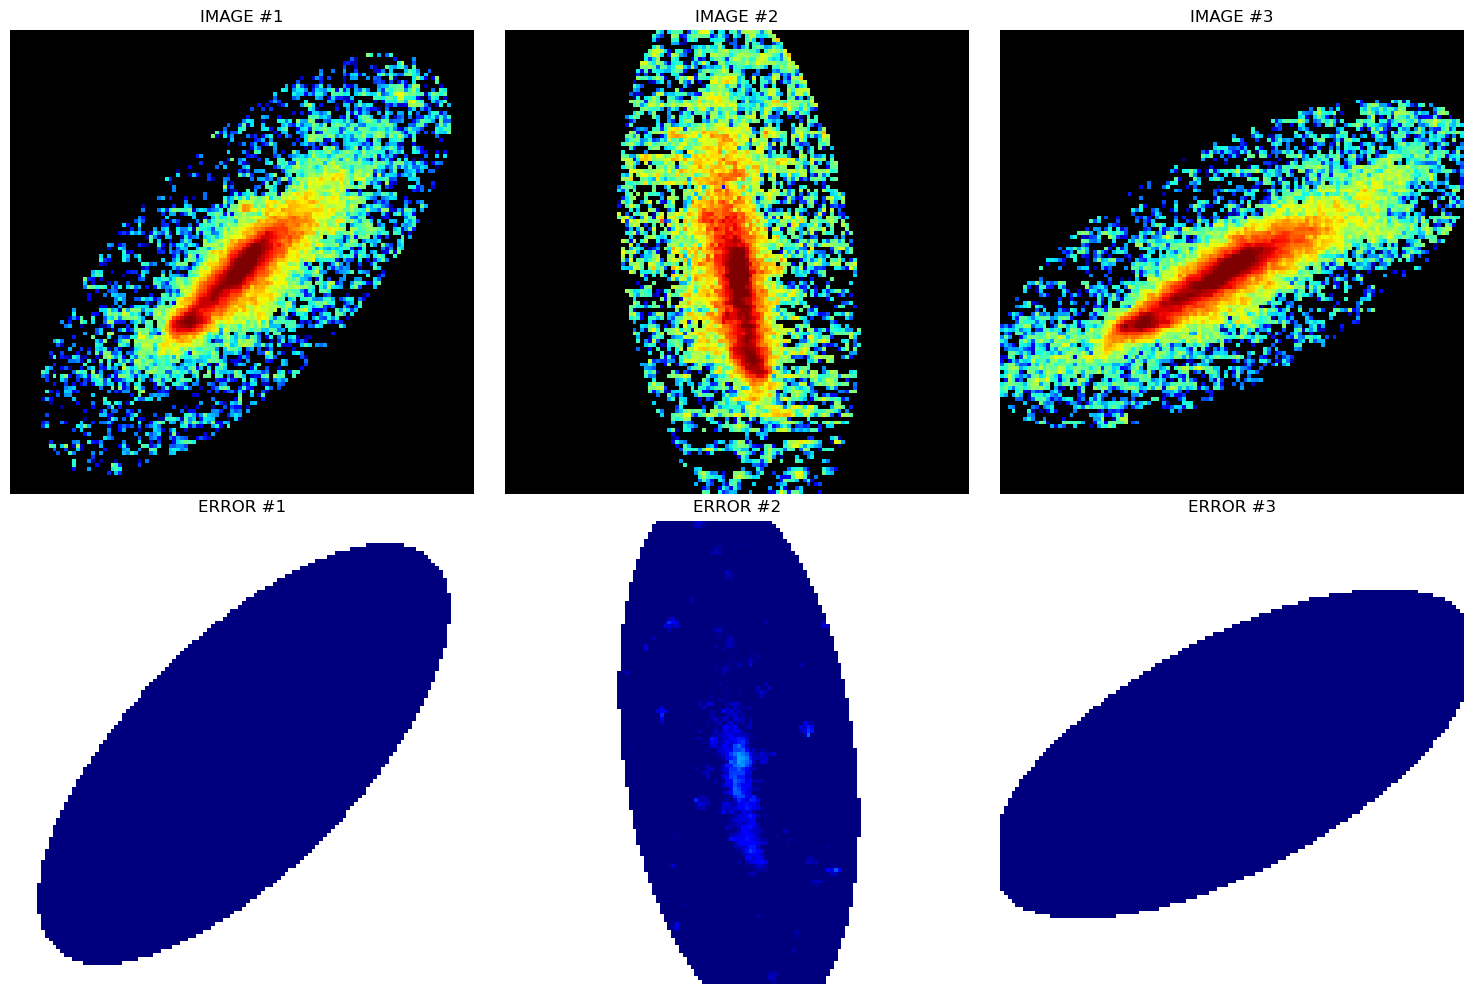

In [17]:
cmap_string = 'jet'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

# Plotting
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

vmin = np.min(np.log10(array200sci))
vmax = np.max(np.log10(array200sci))
print(vmin)
print(vmax)

vmin = -2.5
vmax = -0.5

# Plot sci files in the first row
axs[0, 0].imshow(np.log10(array200sci*likemask), cmap=cmap, vmin=vmin, vmax=vmax)
axs[0, 0].set_title('IMAGE #1')
axs[0, 0].axis('off')

axs[0, 1].imshow(np.log10(array200sci2*likemask2), cmap=cmap, vmin=vmin, vmax=vmax)
axs[0, 1].set_title('IMAGE #2')
axs[0, 1].axis('off')

axs[0, 2].imshow(np.log10(array200sci3*likemask3), cmap=cmap, vmin=vmin, vmax=vmax)
axs[0, 2].set_title('IMAGE #3')
axs[0, 2].axis('off')

vmin = np.min(np.log10(array200err))
vmax = np.max(np.log10(array200err))
print(vmin)
print(vmax)

vmin = -1.5
vmax = -1.0

# Plot err files in the second row
axs[1, 0].imshow(np.log10(array200err*likemask), cmap='jet', vmin=vmin, vmax=vmax)
axs[1, 0].set_title('ERROR #1')
axs[1, 0].axis('off')

axs[1, 1].imshow(np.log10(array200err2*likemask2), cmap='jet', vmin=vmin, vmax=vmax)
axs[1, 1].set_title('ERROR #2')
axs[1, 1].axis('off')

axs[1, 2].imshow(np.log10(array200err3*likemask3), cmap='jet', vmin=vmin, vmax=vmax)
axs[1, 2].set_title('ERROR #3')
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()


In [20]:
np.argmax(array200sci)

7260